In [1]:
import numpy as np
import scipy.sparse as sparse
import math
import matplotlib.pyplot as plt
from mec import make_circle
from Grid import Grid
import copy
import seaborn as sns
import lmfit
from itertools import chain
from scipy import integrate
import random
import pandas as pd
from collections import Counter

In [2]:
def in_circle(point, circle):
    x, y = point
    cx, cy, r = circle
    return np.sqrt((x - cx)**2 + (y - cy)**2) <= r

def distance(p, q):
    return np.sqrt((p[0]-q[0])**2 + (p[1]-q[1])**2)

def independent_gens(gens):
    ind_sets = []
    gen_sets = [set(gen) for gen in gens]

    while gen_sets:
        ind_set = [gen_sets[0]]
        gen_sets.pop(0)

        for i, gen_set in reversed(list(enumerate(gen_sets))):
            add = True
            for gen in ind_set:
                if (gen & gen_set):
                    add = False

            if add:
                ind_set.append(gen_set)
                gen_sets.pop(i)

        if (ind_set):
            ind_sets.append(ind_set)

    return ind_sets

def randomly_draw_generators(m, gamma):
    def in_circle(point, circle):
        x, y = point
        cx, cy, r = circle
        return np.sqrt((x - cx)**2 + (y - cy)**2) <= r

    gens = []
    all_points = [(x,y) for x in range(m) for y in range(m)]

    N = m**2
    L = np.sqrt(2)*((m/2)**gamma)
    while (len(gens) < N):
        cx, cy = random.choice(all_points)

        in_points = [point for point in all_points if in_circle(point, (cx, cy, L))]

        if (len(in_points) >= 5):
            points = random.sample(in_points, 5)
            gens.append(points)

    return gens

In [3]:
def configuration_model(m, gamma):
    # m = 10
    n = m**2

    r = np.sqrt(2)*((m/2)**gamma)
    deg_v = 5 # w_c. Every bit is in this many checks
    deg_c = 5 # w_r. Every check has this many bits in it
    num_checks = (n*deg_v)//deg_c
    k = n - num_checks

    vs = [deg_v for _ in range(n)]
    qbts = [(x,y) for x in range(m) for y in range(m)]
    ops = [[] for i in range(num_checks)]
    
    c_inds = []
    pot_qbts = []
    for i in range(num_checks):
        pot_qbts.append([])
        for j in range(n):
            pot_qbts[i].append(j)
        c_inds.append(i)

    while (np.count_nonzero(vs)):
        if (len(c_inds)):
            c_ind = np.random.choice(c_inds)
        else:
            break

        # choose a v that is within the specified radius (from list of potential qbts)
        v_ind = np.random.choice(pot_qbts[c_ind])
        ops[c_ind].append(qbts[v_ind])
        
        if (len(ops[c_ind]) == deg_c):
            c_inds.remove(c_ind)
        else:
            pot_qbts[c_ind].remove(v_ind)
            if (len(pot_qbts[c_ind]) == 0): c_inds.remove(c_ind)

        # update potential qbts
        # for pot_ind, pot in enumerate(pot_qbts[c_ind]):
        #     if (pot and (make_circle(ops[c_ind] + [qbts[pot_ind]])[2] > r)):
        #         pot_qbts[c_ind][pot_ind] = 0

        if (len(ops[c_ind]) == 1): 
            for i in range(n):
                if (distance(ops[c_ind][0], qbts[i]) > r):
                    if i in pot_qbts[c_ind]:
                        pot_qbts[c_ind].remove(i)
                        if (len(pot_qbts[c_ind]) == 0): c_inds.remove(c_ind)

        vs[v_ind] -= 1
        if (not vs[v_ind]):
            for i in c_inds:
                if v_ind in pot_qbts[i]:
                    pot_qbts[i].remove(v_ind)
                    if (len(pot_qbts[i]) == 0): c_inds.remove(i)


    print(sum(vs))

    # for op in ops:
    #     if (len(op) == 1):
    #         print("Do again")

    return ops

In [ ]:
m = 10
gens = [randomly_draw_generators(m, gamma) for gamma in np.linspace(0,1,11)]
gammas = np.linspace(0, 1, 11)
for i, gen in enumerate(gens):
    print(np.mean([make_circle(op)[2] for op in gen]), np.sqrt(2)*(m/2)**gammas[i])

In [ ]:
gens = [configuration_model(10, gamma) for gamma in np.linspace(0, 1, 11)]
gammas = np.linspace(0, 1, 11)
for i, gen in enumerate(gens):
    print(np.mean([make_circle(op)[2] for op in gen]), np.sqrt(2)*(10/2)**gammas[i])

In [ ]:
gammas = np.linspace(0, 1, 11)
for i, gen in enumerate(gens):
    print(np.mean([make_circle(op)[2] for op in gen]), (10/2)**gammas[i])

In [ ]:
points = [(4, 6),(3, 7),(4, 7),(4, 8)]
make_circle(points)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(5,5))


ind_sets = independent_gens(ops)

all_points = [(x,y) for x in range(m) for y in range(m)]
xs, ys = zip(*all_points)
ax.scatter(xs, ys)


i = 0
ind_set = [list(s) for s in ind_sets[i]]
gen_xs, gen_ys = zip(*list(chain(*ind_set)))
ax.scatter(gen_xs, gen_ys, c='r', s=70)

ax.axis('off')
plt.show()

In [ ]:
grid = Grid(m, deg_v)

for ind_set in ind_sets:
    print(grid.greedy_route_set(ind_set))

In [ ]:
print(ind_sets[1])

In [ ]:
grid = Grid(10, 5)

# s = [{(6, 6), (8, 8), (7, 6), (8, 6)}, {(7, 7), (8, 7), (7, 9), (9, 8), (9, 7)}, {(5, 5), (5, 4), (6, 4), (5, 3), (7, 5)}, {(4, 0), (5, 1), (3, 0), (5, 0), (4, 1)}, {(3, 7), (1, 6), (2, 7), (1, 5)}, {(5, 9), (6, 9), (4, 8), (5, 8)}, {(1, 7), (2, 6), (3, 6), (2, 5), (3, 5)}, {(1, 2), (2, 1), (3, 1), (1, 1), (1, 3)}, {(6, 2), (8, 4), (7, 3), (8, 3), (6, 3)}, {(2, 9), (0, 8), (0, 9)}, {(4, 4), (2, 4), (4, 3), (4, 2), (3, 2)}, {(7, 0), (9, 2), (8, 0)}, {(6, 7), (8, 9)}, {(0, 6)}, {(7, 1), (8, 1), (6, 1), (6, 0), (8, 2)}, {(9, 5), (9, 6), (9, 4)}]
s = [{(2, 2), (2, 4), (3, 3), (3, 4), (4, 4)}]
grid.greedy_route_set(s)

In [ ]:
for op in s:
    grid = Grid(10,5)
    print(grid.greedy_route_set(s))

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(5,5))

i = 5

# pot_qbt_inds = [qbts[j] for j in pot_qbts[i]]
xs, ys = zip(*qbts)
op_xs, op_ys = zip(*ops[i])
# pot_xs, pot_ys = zip(*pot_qbt_inds)

cir = make_circle(ops[i])
c = plt.Circle((cir[0], cir[1]), cir[2], alpha=0.3)
ax.scatter(xs, ys, c='k')
ax.scatter(op_xs, op_ys, c='r')
# ax.scatter(pot_xs, pot_ys, c='b')


ax.add_artist(c)
ax.axis('off')
plt.show()

(array([7.56518588e-01, 3.07415027e-01, 1.79099724e-01, 1.08847942e-01,
        7.07596262e-02, 4.94301695e-02, 3.19941851e-02, 2.94549640e-02,
        1.98059241e-02, 1.79438287e-02, 1.64202960e-02, 1.20189796e-02,
        1.13418540e-02, 7.61766311e-03, 5.92484909e-03, 6.77125610e-03,
        6.09413049e-03, 5.58628628e-03, 5.24772348e-03, 4.40131646e-03,
        4.23203506e-03, 4.06275366e-03, 3.38562805e-03, 1.86209543e-03,
        1.86209543e-03, 3.04706524e-03, 2.03137683e-03, 2.53922104e-03,
        2.20065823e-03, 6.77125610e-04, 2.03137683e-03, 1.69281402e-03,
        1.69281402e-03, 1.01568841e-03, 1.69281402e-03, 1.52353262e-03,
        1.01568841e-03, 1.18496982e-03, 1.01568841e-03, 1.35425122e-03]),
 array([ 1.00020337,  1.59093572,  2.18166806,  2.77240041,  3.36313276,
         3.9538651 ,  4.54459745,  5.13532979,  5.72606214,  6.31679448,
         6.90752683,  7.49825918,  8.08899152,  8.67972387,  9.27045621,
         9.86118856, 10.45192091, 11.04265325, 11.6333856 ,

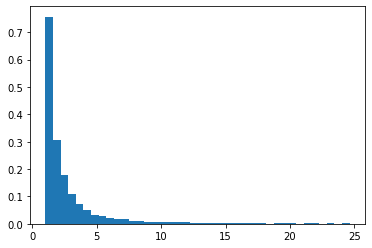

In [6]:
# https://stats.stackexchange.com/questions/508749/generating-random-samples-obeying-the-exponential-distribution-with-a-given-min

a = 4
M = 50
def f(x):
    return a*np.exp(-a*x)
    # return 1 - np.exp(-a*x)
def f_inv(x):
    return -(1/a)*np.log(x/a)

points = []
points_scaled = []
for i in range(10000):
    points.append((M/2)**random.uniform(0,1))
    points_scaled.append((M/2)**f_inv(random.uniform(f(0), f(1))))
    # points_scaled.append(random.uniform(0,1))

# plt.hist(points, bins=20, density=True)
# print(np.mean(points_scaled))
plt.hist(points_scaled, bins=40, density=True)

(array([5.09229051, 0.27985903]), array([[ 1.58343975e-02, -6.65790029e-04],
       [-6.65790029e-04,  2.84759304e-05]]))
(array([0.51133323, 0.52275233]), array([[ 5.82528498e-04, -2.37991289e-04],
       [-2.37991289e-04,  9.82459912e-05]]))


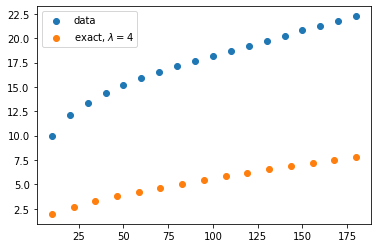

In [127]:
import scipy.integrate as integrate
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import pandas as pd

def fit_fun(M, c, beta):
    # g(y) is the distribution function
    def g(x):
        # return 1
        l = a
        return (l/(1-np.exp(-l))) * np.exp(-l*x)

    integrand = lambda y: g(y) * (M**y)

    return c * integrate.quad(integrand, 0, 1)[0] * M**((2*beta)-2)

k = 5
beta = 1
type = f"a_{a}"
# type = "uniform"
df = pd.read_csv(f"../results/k_{k}/res_files_dist/{type}/combined_res.res")

tmp_df = df[(df['beta'] == round(beta, 1)) & (df['gamma'] == 0)]
plt.scatter(tmp_df['m'], tmp_df['mean'], label='data')

print(curve_fit(lambda x, c, a: c*x**a, tmp_df['m'], tmp_df['mean']))

xs = np.linspace(10, max(tmp_df['m']), 15)
ys = [fit_fun(x, 1, beta) for x in xs]

plt.scatter(xs, ys, label=f'exact, $\lambda={a}$')
print(curve_fit(lambda x, c, a: c*x**a, xs, ys))

plt.legend()

# plt.savefig(f'../figures/notes4b.png', dpi=600, transparent=False, bbox_inches='tight')


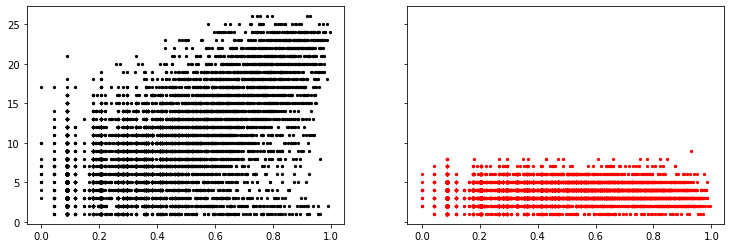

In [166]:
import pandas as pd
fig, ax = plt.subplots(1, 2, figsize=(12.5, 4), sharex=True, sharey=True)


M = 100
df = pd.read_csv("../results/notes/exp2_rounds.csv", names=["radii", "rt_end", "rt_len"])
df.dropna(inplace=True)

df["log_r"] = [math.log(a, M/2) for a in df["radii"].values]
df["rounded_log_r"] = df["log_r"].apply(lambda x: math.floor(x * 10) / 10)
df = df[df["log_r"] < 1]

# plt.xlabel("Generator radius, $\gamma$")
# plt.ylabel("Num rounds to route")
ax[0].scatter(df["log_r"], df["rt_end"], c='k', s=5)
ax[1].scatter(df["log_r"], df["rt_len"], c='r', s=5)

# plt.savefig(f'../figures/notes5.png', dpi=600, transparent=False, bbox_inches='tight')


Text(0, 0.5, 'Num rounds to route')

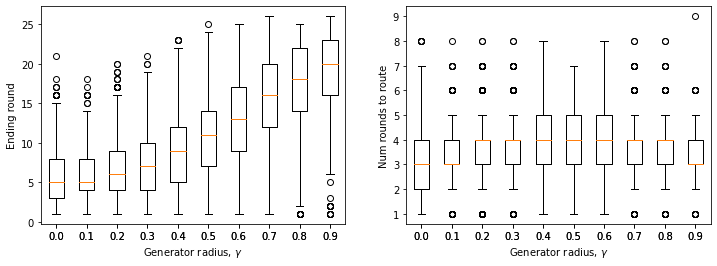

In [167]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4), sharex=True)


tmp_dfs_end = []
tmp_dfs_len = []

gammas = sorted(df["rounded_log_r"].unique())
for gamma in gammas:
    tmp_df = df[df["rounded_log_r"] == gamma]
    tmp_dfs_end.append(tmp_df["rt_end"])
    tmp_dfs_len.append(tmp_df["rt_len"])


ax[0].boxplot(tmp_dfs_end, labels=[str(g) for g in gammas])
ax[1].boxplot(tmp_dfs_len, labels=[str(g) for g in gammas])

# plt.bar([str(g) for g in gammas], means, align="center")
# plt.xticks(np.arange(len(gammas)), gammas)
ax[0].set_xlabel('Generator radius, $\gamma$')
ax[0].set_ylabel('Ending round')

ax[1].set_xlabel('Generator radius, $\gamma$')
ax[1].set_ylabel('Num rounds to route')

# plt.savefig(f'../figures/notes10.png', dpi=600, transparent=False, bbox_inches='tight')


Text(0.5, 0, 'Num rounds')

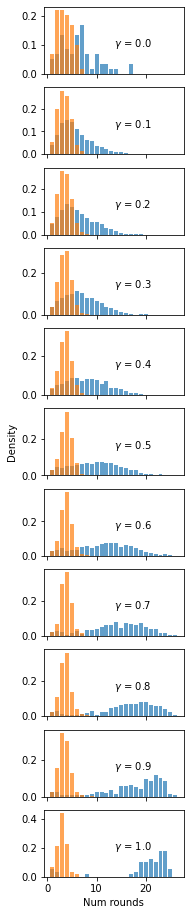

In [130]:
fig, ax = plt.subplots(11, 1, figsize=(2.5, 16), sharex=True, sharey=False)

for i, gamma in enumerate(gammas):
    tmp_df = df[df["rounded_log_r"] == gamma]
    c = Counter(tmp_df["rt_end"])
    ax[i].bar(c.keys(), [v/len(tmp_df) for v in c.values()], label="End", alpha=0.7)

    c = Counter(tmp_df["rt_len"])
    ax[i].bar(c.keys(), [v/len(tmp_df) for v in c.values()], label="Length", alpha=0.7)

    ax[i].text(0.5, 0.4, f"$\gamma$ = {gamma}",transform=ax[i].transAxes)
    # ax[i].set_title(f"$\gamma$ = {gamma}")
ax[5].set_ylabel("Density")
# plt.legend()
ax[-1].set_xlabel("Num rounds")

# plt.savefig(f'../figures/notes10.png', dpi=600, transparent=False, bbox_inches='tight')


In [74]:
# https://math.stackexchange.com/questions/3993770/numerical-integration-solve-upper-bound-given-integral

l = 4
def newtons(p, b0, n):
    g = lambda x: (l/(1-np.exp(-l))) * np.exp(-l*x)
    gint = lambda x: integrate.quad(g, 0, x)[0]

    bn = b0
    for i in range(n):
        bn = bn - (gint(bn)-p)/g(bn)

    return bn

perc = 0.9
cutoff = newtons(perc, 0, 10)
print(cutoff)

0.5375001776500494


In [75]:
M = 10e4

def g(x):
    # return 1
    return (l/(1-np.exp(-l))) * np.exp(-l*x)

integrand = lambda y: g(y) * (M**y) * M**2


# print(integrate.quad(g, 0, 0.4647706948496652)[0])
# print(1.85*integrate.quad(integrand, 0, 0.4647706948496652)[0] + 6.35)
tot_edges = integrate.quad(integrand, 0, 1)[0]
sm_edges = integrate.quad(integrand, 0, cutoff)[0]
lg_edges = integrate.quad(integrand, cutoff, 1)[0]

print(sm_edges/tot_edges)
print(lg_edges/tot_edges)


0.030440935756821854
0.9695590642431783


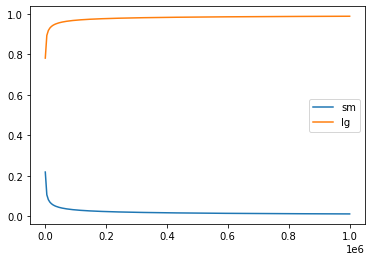

In [71]:
sm = []
lg = []
tot = []
ms = np.linspace(10e2, 10e5, 200)

for M in ms:
    integrand = lambda y: g(y) * (M**y)

    tot.append(integrate.quad(integrand, 0, 1)[0])
    sm.append(integrate.quad(integrand, 0, cutoff)[0])
    lg.append(integrate.quad(integrand, cutoff, 1)[0])


plt.plot(ms, [s/t for s,t in zip(sm, tot)], label='sm')
plt.plot(ms, [s/t for s,t in zip(lg, tot)], label='lg')

# plt.plot(ms, sm, label='sm')
# plt.plot(ms, lg, label='lg')
# plt.plot(ms, np.log(ms))
plt.legend()

(array([0.11174641, 0.36152896]), array([[ 1.37412822e-08, -2.57344259e-09],
       [-2.57344259e-09,  4.82020578e-10]]))


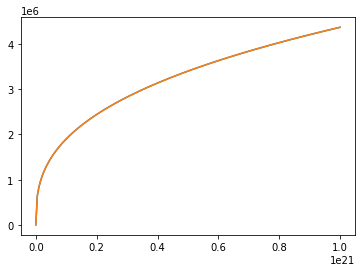

In [109]:
from scipy.optimize import curve_fit

def f(x, c, g):
    return c*x**g

arr = sm
res = curve_fit(f, ms, arr)
print(res)
plt.plot(ms, f(ms, *res[0]))
plt.plot(ms, arr)

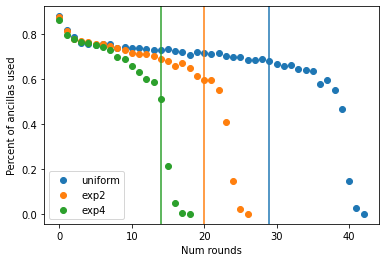

In [124]:
M = 100

ts = ["uniform", "exp2", "exp4"]
cs = ['tab:blue', 'tab:orange', 'tab:green']

for i, t in enumerate(ts):
    df = pd.read_csv(f"../results/notes/{t}_efficiency.csv", names=["round", "used", "available", "perc"])
    df.dropna(inplace=True)

    df2 = pd.read_csv(f"../results/notes/{t}_rounds.csv", names=["radii", "rt_end", "rt_len"])
    df2.dropna(inplace=True)

    df2["log_r"] = [math.log(a, M/2) for a in df2["radii"].values]
    df2["rounded_log_r"] = round(df2["log_r"], 1)

    tmp_dfs_end = []
    tmp_dfs_len = []

    gammas = sorted(df2["rounded_log_r"].unique())
    for gamma in gammas:
        tmp_df = df2[df2["rounded_log_r"] == gamma]
        tmp_dfs_end.append(tmp_df["rt_end"])
        tmp_dfs_len.append(tmp_df["rt_end"] - tmp_df["rt_len"])

    # plt.axvline(x=np.median(tmp_dfs_len[-1]), c='k')
    plt.axvline(x=np.median(tmp_dfs_end[-2]), c=cs[i])
    plt.scatter(df["round"], 1-df["perc"], label=f"{t}")

plt.xlabel("Num rounds")
plt.ylabel("Percent of ancillas used")
plt.legend(loc='lower left')

plt.savefig(f'../figures/notes11.png', dpi=600, transparent=False, bbox_inches='tight')


In [104]:
M = 100

rounds = []
completion = []

with open("../results/tmp.csv") as f:
    for line in f.readlines():
        if ("ROUNDS:" in line):
            rounds.append(line.replace("ROUNDS:", "").strip().split(","))
        else:
            completion.append(line.strip().split(","))

Text(0.5, 0, 'Rounds')

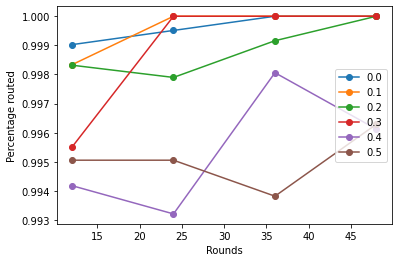

In [105]:
df = pd.DataFrame(completion, columns=["r", "key", "round", "cycle", "routed"], dtype=float)
df["log_r"] = [math.log(a, M/2) for a in df["r"].values]
df["rounded_log_r"] = df["log_r"].apply(lambda x: math.floor(x * 10) / 10)
# df["rounded_log_r"] = round(df["log_r"], 1)

df = df[df["log_r"] < 1]

gammas = sorted(df["rounded_log_r"].unique())
restarts = sorted(df["round"].unique())

for gamma in gammas:
    respawns = []
    successes = []

    tmp_df = df[df["rounded_log_r"] == gamma]

    for restart in restarts:
        tmp_df2 = tmp_df[tmp_df["round"] == restart]
        num = len(tmp_df2[tmp_df2["routed"] == 1])
        # print(len(tmp_df2), end=" ")

        respawns.append(np.mean(tmp_df2["round"]))
        successes.append(num/len(tmp_df2))

    plt.plot(respawns, successes, label=str(gamma), marker='o')

plt.legend(loc='right')
plt.ylabel("Percentage routed")
plt.xlabel("Rounds")

# plt.savefig(f'../figures/notes12a.png', dpi=600, transparent=False, bbox_inches='tight')


Text(0.5, 0, 'Rounds')

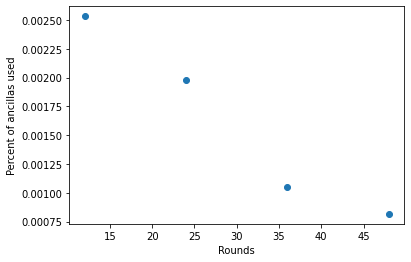

In [106]:
arr = pd.DataFrame(rounds, columns=["round", "num_anc", "tot_anc", "perc"], dtype=float)
plt.scatter(arr["round"], 1-arr["perc"])
plt.ylabel("Percent of ancillas used")
plt.xlabel("Rounds")

# plt.savefig(f'../figures/notes12b.png', dpi=600, transparent=False, bbox_inches='tight')
# 

Text(0.5, 0, 'Rounds')

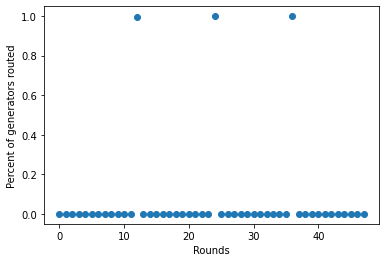

In [107]:
perc = []
for i in np.arange(max(df["round"])):
    tmp_df = df[df["round"] == i]

    if (len(tmp_df) != 0):
        perc.append(len(tmp_df[tmp_df["routed"] == 1])/len(tmp_df))
    else:
        perc.append(0)

plt.scatter(np.arange(max(df["round"])), perc)
plt.ylabel("Percent of generators routed")
plt.xlabel("Rounds")

# plt.savefig(f'../figures/notes12c.png', dpi=600, transparent=False, bbox_inches='tight')
